# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

If you do not have a GPU, uncomment and run the next commands.


In [1]:
import sys
sys.version

'3.9.16 (main, Mar  8 2023, 14:00:05) \n[GCC 11.2.0]'

In [2]:
! python --version

/usr/bin/zsh: /home/ramez/miniconda3/envs/thesis/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Python 3.9.16


In [3]:
! which python

/usr/bin/zsh: /home/ramez/miniconda3/envs/thesis/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
/home/ramez/miniconda3/envs/thesis/bin/python


In [4]:
import tensorflow as tf

#### GPU Check

In [5]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

/usr/bin/zsh: /home/ramez/miniconda3/envs/thesis/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Limit GPU memory usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=0.7)])

In [7]:
from tensorflow import keras

In [8]:
import numpy as np

In [9]:
from sklearn.metrics import cohen_kappa_score

In [10]:
## Local EfficientNetLite (Customized by the Competition)
from efficientnet_lite import EfficientNetLiteB0

In [11]:
from sklearn.model_selection import KFold

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Flatten

In [13]:
from tensorflow.keras.callbacks import TensorBoard

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
import matplotlib.pyplot as plt

In [16]:
from itertools import accumulate

In [17]:
import os

In [18]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [19]:
import pandas as pd

In [20]:
from sklearn.metrics import accuracy_score

# 2. Utility Functions

You can use this function to load your training data.

In [21]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=config.input_shape[:2], shuffle=False, 
                                                               batch_size=100000, label_mode='int')

    # get the class names (folder names) from the dataset object
    global class_names
    class_names = tf_eval_data.class_names
    
    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

# 4. Loading data

In [22]:
## test Variation
# dataset_path_train_val = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/Data/ops_sat_train/"
# dataset_path_train_val = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Original/train/"
# dataset_path_train_val = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Augmentation/train/"
# dataset_path_train_val = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Synthetic_Generation/train/"
# dataset_path_train_val = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Synthetic_Generation_color_corrected/train/"
dataset_path_train_val = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Synthetic_Generation_color_corrected_Augmentation/train/"

In [23]:
## Test Variation
# dataset_path_test = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/Data/ops_sat_test/"
# dataset_path_test = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Original/test/"
# dataset_path_test = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Augmentation/test/"
# dataset_path_test = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Synthetic_Generation/test/"
# dataset_path_test = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Synthetic_Generation_color_corrected/test/"
dataset_path_test = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/the_opssat_case_starter_kit-main/Data/Variation_Synthetic_Generation_color_corrected_Augmentation/test/"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

### Model Configuration

In [24]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="OPS-SAT-Thesis-Project",

    # track hyperparameters and run metadata with wandb.config
    config={
        "dropout": 0.5,
        "num_classes": 8,
        "input_shape": (200, 200, 3),
        "model_weights": "OpenSurfaces",
        "output_layer_activation": "softmax",
        "model_optimizer": "adam",
        "loss_fun": "FocalLoss",
        # "loss_fun": "SparseCategoricalCrossentropy",
        "model_metrics": ["SparseCategoricalAccuracy"],
        "early_stopping_monitor": "val_sparse_categorical_accuracy",
        "early_stopping_patience": 3,
        "model_checkpoint_monitor": "val_sparse_categorical_accuracy",
        "cross_validation_k": 5,
        "model_epochs": 200,
        "model_batch_size": 4,
        "alpha_focal_loss": 0.2, # 0-1 (0.2)
        "gamma_focal_loss": 2,  # 1-5 (2,3)
        "n_freeze_layers" : 100
    }
)

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ramezashendy (ramez). Use `wandb login --relogin` to force relogin


In [25]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(CustomLoss, self).__init__(**kwargs)
        self.scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    def call(self, y_true, y_pred):
        return self.scce(y_true, y_pred)

In [26]:
def sparse_categorical_focal_loss(y_true, y_pred, gamma=config.gamma_focal_loss, alpha=config.alpha_focal_loss):
    # Convert target labels to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), tf.shape(y_pred)[-1])

    # Compute cross-entropy loss
    cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred)

    # Compute focal weights based on the probability predictions
    p_t = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
    focal_weights = tf.pow(1 - p_t, gamma)

    # Apply focal weights to the cross-entropy loss
    loss = alpha * focal_weights * cross_entropy

    return loss

In [27]:
custom_loss_functions = {
    # 'SparseCategoricalCrossentropy': CustomLoss
    'FocalLoss': sparse_categorical_focal_loss
}

In [28]:
#Loading dataset
x_train_val, y_train_val = get_images_from_path(dataset_path_train_val)

Found 1600 files belonging to 8 classes.


In [29]:
## class_names_labels dict
class_name_label = {}
for i, class_name in enumerate(class_names):
    class_name_label[i] = class_name

In [30]:
#Loading dataset
x_test, y_test = get_images_from_path(dataset_path_test)

Found 40 files belonging to 8 classes.


In [31]:
## class_names_labels dict
class_name_label_test = {}
for i, class_name in enumerate(class_names):
    class_name_label_test[i] = class_name

In [32]:
## Check if classes are identical with labels in both splits
if class_name_label == class_name_label_test:
    print("Ok")
else:
    print("Error - Class Mapping Are Mismatched")

Ok


### Logging Info about the Dataset

In [33]:
train_val_len = len(x_train_val)
test_len = len(x_test)
dataset_name = "The OPS-SAT case dataset"
dataset_variation_description = "Augmentated Color Corrected Synthetic Variation"
dataset_train_val_path = dataset_path_train_val

In [34]:
dataset_info = {"Dataset Name": dataset_name, 
                "Training Validation Set Size": train_val_len,
                "Test Set Size": test_len,
                "Dataset Variation Description": dataset_variation_description,
                "Train Val Set Path":dataset_path_train_val,
                "Test Set Path": dataset_path_test}
# Log dictionary to wandb
wandb.log(dataset_info)

# 5. Model training

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

### Load The Model With ImageNet Weights

### Compile The model

### Early Stopping and Best Model Callbacks 

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [35]:
# custom_loss = custom_loss_functions[config.loss_fun]()
custom_loss = custom_loss_functions[config.loss_fun]

## Weight Initialization Imagenet

In [36]:
# def model_init():
#     global model
#     global early_stopping
#     global checkpoint
    
#     model = EfficientNetLiteB0(classes=config.num_classes, weights=config.model_weights, input_shape=config.input_shape, classifier_activation=None, include_top = False)
#     x = model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(config.dropout)(x)
#     output_layer = Dense(config.num_classes, activation=config.output_layer_activation)(x)
#     model = Model(inputs=model.input, outputs=output_layer)
#     # model.summary()
    
#     model.compile(optimizer=config.model_optimizer,
#                   # loss="sparse_categorical_crossentropy",
#               # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
#                   # loss=config.loss_fun,
#                   loss=custom_loss,
#                   # metrics=[keras.metrics.SparseCategoricalAccuracy()],
#                  metrics=config.model_metrics)
    
#     early_stopping = EarlyStopping(monitor=config.early_stopping_monitor, patience=config.early_stopping_patience)
#     checkpoint = ModelCheckpoint('best_weights.h5', monitor=config.model_checkpoint_monitor, save_best_only=True)
    
# # wandb_callback=wandb.keras.WandbCallback()

## Transfer Learning (Fine-tuning) - Imagenet

In [37]:
# def model_init():
#     global model
#     global early_stopping
#     global checkpoint
    
#     # Load the pre-trained EfficientNetLiteB0 model without the top classification layer
#     base_model = EfficientNetLiteB0(weights=config.model_weights, input_shape=config.input_shape, include_top=False)
    
#     total_layers = len(base_model.layers)
#     print("Total layers in the base model:", total_layers)
    
#     # Freeze the early n layers of the base model
#     n_layers_to_freeze = config.n_freeze_layers
#     for layer in base_model.layers[:n_layers_to_freeze]:
#         layer.trainable = False

#     # Build the top layers for classification
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(config.dropout)(x)
#     output_layer = Dense(config.num_classes, activation=config.output_layer_activation)(x)
#     model = Model(inputs=base_model.input, outputs=output_layer)
    
#     # model.summary()
    
    
#     model.compile(optimizer=config.model_optimizer,
#                   loss=custom_loss,
#                   metrics=config.model_metrics)
    
#     early_stopping = EarlyStopping(monitor=config.early_stopping_monitor, patience=config.early_stopping_patience)
#     checkpoint = ModelCheckpoint('best_weights.h5', monitor=config.model_checkpoint_monitor, save_best_only=True)


## Transfer Learning (Fine tuning) - OpenSurfaces dataset

In [50]:
def model_init():
    global model
    global early_stopping
    global checkpoint
    
    # Load the pre-trained EfficientNetLiteB0 model without the top classification layer
    # base_model = EfficientNetLiteB0(weights=config.model_weights, input_shape=config.input_shape, include_top=False)
    
    # base_model = EfficientNetLiteB0(weights="../Data/model_patterns_20epochs.h5", input_shape=config.input_shape, include_top=False)
    base_model = EfficientNetLiteB0(classes=config.num_classes, weights=None, input_shape=config.input_shape, classifier_activation=None)
    base_model.load_weights('../Data/model_patterns_20epochs.h5')
    
    total_layers = len(base_model.layers)
    print("Total layers in the base model:", total_layers)
    
    # Freeze the early n layers of the base model
    n_layers_to_freeze = config.n_freeze_layers
    for layer in base_model.layers[:n_layers_to_freeze]:
        layer.trainable = False

    # Build the top layers for classification
    x = base_model.output
    x = Flatten()(x)  # Use Flatten layer instead of GlobalAveragePooling2D
    x = Dropout(config.dropout)(x)
    output_layer = Dense(config.num_classes, activation=config.output_layer_activation)(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    model.compile(optimizer=config.model_optimizer,
                  loss=custom_loss,
                  metrics=config.model_metrics)
    
    early_stopping = EarlyStopping(monitor=config.early_stopping_monitor, patience=config.early_stopping_patience)
    checkpoint = ModelCheckpoint('best_weights.h5', monitor=config.model_checkpoint_monitor, save_best_only=True)


### Without K fold Cross Validation but with TensorBoard (With Early Stopping)

In [51]:
# tensorboard_callback = TensorBoard(log_dir='./logs')

In [52]:
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# history = model.fit(x_train_val, y_train_val, validation_data=(x_test, y_test), epochs= 100, verbose=1, batch_size=8, 
#                         callbacks=[early_stopping, tensorboard_callback])

In [53]:
# !tensorboard --logdir=./logs

### With K fold Cross Validation but without TensorBoard (With Early Stopping)

In [54]:
kf = KFold(n_splits=config.cross_validation_k, shuffle=True)

In [55]:
# Train and evaluate the model using K-fold cross-validation
scores = []
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

## Initializing the model
model_init()

## counter for folds
i = 1

for train_idx, val_idx in kf.split(x_train_val):
    X_train = tf.gather(x_train_val, train_idx)
    y_train = tf.gather(y_train_val, train_idx)
    X_val = tf.gather(x_train_val, val_idx)
    y_val = tf.gather(y_train_val, val_idx)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= config.model_epochs, verbose=1, batch_size=config.model_batch_size, 
                        callbacks=[early_stopping, checkpoint])

    training_accuracy.append(history.history['sparse_categorical_accuracy'])
    validation_accuracy.append(history.history['val_sparse_categorical_accuracy'])
    training_loss.append(history.history['loss'])
    validation_loss.append(history.history['val_loss'])
    
    model.load_weights('best_weights.h5')
    score = model.evaluate(X_val, y_val)
    scores.append(score[1])
    
    wandb.log({"Best Validation Loss for Folds": score[0]})
    wandb.log({"Best Validation Accuracy for Folds" : score[1]})
    
    # Define the current and new file names
    current_name = 'best_weights.h5'
    new_name = 'fold_' + str(i) + '_best_model_weights.h5'
    
    i+=1

    ## Rename the file
    os.rename(current_name, new_name)
    ## Log the model to wandb
    wandb.save(new_name)
    
    ## Reseting the model for the next fold
    model_init()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Total layers in the base model: 157
Epoch 1/200


2023-07-20 15:16:37.665047: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 9.2.148, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


80/80 [==============================] - ETA: 0s - loss: 0.3242 - sparse_categorical_accuracy: 0.2297

/home/ramez/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


80/80 [==============================] - 21s 199ms/step - loss: 0.3242 - sparse_categorical_accuracy: 0.2297 - val_loss: 0.2446 - val_sparse_categorical_accuracy: 0.3250
Epoch 2/200
80/80 [==============================] - 16s 200ms/step - loss: 0.2638 - sparse_categorical_accuracy: 0.3336 - val_loss: 0.2090 - val_sparse_categorical_accuracy: 0.4625
Epoch 3/200
80/80 [==============================] - 16s 194ms/step - loss: 0.2295 - sparse_categorical_accuracy: 0.4320 - val_loss: 0.1502 - val_sparse_categorical_accuracy: 0.6062
Epoch 4/200
80/80 [==============================] - 15s 190ms/step - loss: 0.1960 - sparse_categorical_accuracy: 0.5320 - val_loss: 0.1123 - val_sparse_categorical_accuracy: 0.5906
Epoch 5/200
80/80 [==============================] - 16s 195ms/step - loss: 0.1750 - sparse_categorical_accuracy: 0.5617 - val_loss: 0.0652 - val_sparse_categorical_accuracy: 0.7875
Epoch 6/200
80/80 [==============================] - 15s 191ms/step - loss: 0.1525 - sparse_categorica

In [56]:
# Print the mean validation accuracy
print('Validation accuracy mean: {:.2f} (std {:.2f})'.format(np.mean(scores), np.std(scores)))

Validation accuracy mean: 0.95 (std 0.01)


In [57]:
wandb.log({"Folds Validation Accuracy Mean" : np.mean(scores),
           "Folds Validation Accuracy STD": np.std(scores)})

In [58]:
scores

[0.9593750238418579, 0.9437500238418579, 0.9312499761581421, 0.96875, 0.953125]

Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

## Model with best validation accuracy

In [59]:
## select the model with the best fold's validation accuracy
maximum = max(scores)
index_of_maximum = scores.index(maximum)
best_fold = index_of_maximum + 1

model.load_weights('fold_' + str(best_fold) + '_best_model_weights.h5')

### Model with best validation accuracy Kohen's Kappa Score

In [60]:
predictions = np.zeros(len(y_test), dtype=np.int8)
# inference loop
for e, (image, target) in enumerate(zip(x_test, y_test)):
    image = np.expand_dims(np.array(image), axis=0)
    output = model.predict(image)
    predictions[e] = np.squeeze(output).argmax()
#Keras model score
score_keras = cohen_kappa_score(y_test.numpy(), predictions)
print("Score:", score_keras)

Score: 0.4


### Log Cohen Kappa Score for the model with the best validation accuracy (Unifeied Test Set)

In [61]:
wandb.log({"Cohen Kappa Score for model with best validation accuracy (Unified Test Set)": score_keras})

### Acuracy for model with best validation accuracy (Unified Test Set)

In [62]:
# assuming you have two lists, predicted and actual
correct = 0
total = len(y_test.numpy())

for pred, label in zip(predictions, y_test.numpy()):
    if pred == label:
        correct += 1

accuracy = correct / total

print("Accuracy: ", accuracy)

Accuracy:  0.475


### Log Accuracy for the model with the best validation accuracy (Unifeied Test Set)

In [63]:
wandb.log({"Accuracy for model with best validation accuracy (Unified Test Set)": accuracy})

## Ensemble model from the k trained models

In [64]:
models = []
for i in range(1, (config.cross_validation_k + 1)):
    # models.append(keras.models.load_model('fold_' + str(i) + '_best_model_weights.h5', custom_objects={'CustomLoss': custom_loss}))
    models.append(keras.models.load_model('fold_' + str(i) + '_best_model_weights.h5', custom_objects={'sparse_categorical_focal_loss': custom_loss}))
    
y_preds = []
for model in models:
    y_pred = model.predict(x_test)
    y_preds.append(y_pred)
    
# combine the predictions using voting or averaging
y_ensemble = sum(y_preds) / config.cross_validation_k

### Ensemble model Kohen's Kappa Score

In [65]:
predictions = np.zeros(len(y_test), dtype=np.int8)
# inference loop
for e, (image, target) in enumerate(zip(x_test, y_test)):
    image = np.expand_dims(np.array(image), axis=0)
    output = y_ensemble[e]
    predictions[e] = np.squeeze(output).argmax()
#Keras model score
score_keras = cohen_kappa_score(y_test.numpy(), predictions)
print("Score:",score_keras)

Score: 0.4285714285714286


### Log Cohen Kappa Score for the ensemble model (Unifeied Test Set)

In [66]:
wandb.log({"Cohen Kappa Score for the ensemble model (Unified Test Set)": score_keras})

### Accuracy 

In [67]:
# assuming you have two lists, predicted and actual
correct = 0
total = len(y_test.numpy())

for pred, label in zip(predictions, y_test.numpy()):
    if pred == label:
        correct += 1

accuracy = correct / total

print("Accuracy: ", accuracy)

Accuracy:  0.5


### Log Accuracy for the ensemble model (Unifeied Test Set)

In [68]:
wandb.log({"Accuracy for the ensemble model (Unified Test Set)": accuracy})

## Train - Validation Visualization

In [69]:
eps_per_fold = [len(sub_list) for sub_list in training_accuracy]
eps_per_fold

[15, 13, 14, 16, 19]

In [70]:
eps_per_fold_cum = list(accumulate(eps_per_fold))

In [71]:
training_accuracy = [element for sublist in training_accuracy for element in sublist]
validation_accuracy = [element for sublist in validation_accuracy for element in sublist]
training_loss = [element for sublist in training_loss for element in sublist]
validation_loss = [element for sublist in validation_loss for element in sublist]

In [72]:
eps_per_fold_cum

[15, 28, 42, 58, 77]

In [73]:
xs = []
ys = []
for i in range(config.cross_validation_k):
    xs.append(eps_per_fold_cum[i]+1)
    ys.append(training_accuracy[eps_per_fold_cum[0]-1])
# xs = [eps_per_fold_cum[0]+1, eps_per_fold_cum[1]+1, eps_per_fold_cum[2]+1, eps_per_fold_cum[3]+1, eps_per_fold_cum[4]+1]
# ys = [training_accuracy[eps_per_fold_cum[0]-1], training_accuracy[eps_per_fold_cum[1]-1], training_accuracy[eps_per_fold_cum[2]-1],
#          training_accuracy[eps_per_fold_cum[3]-1], training_accuracy[eps_per_fold_cum[4]-1]]

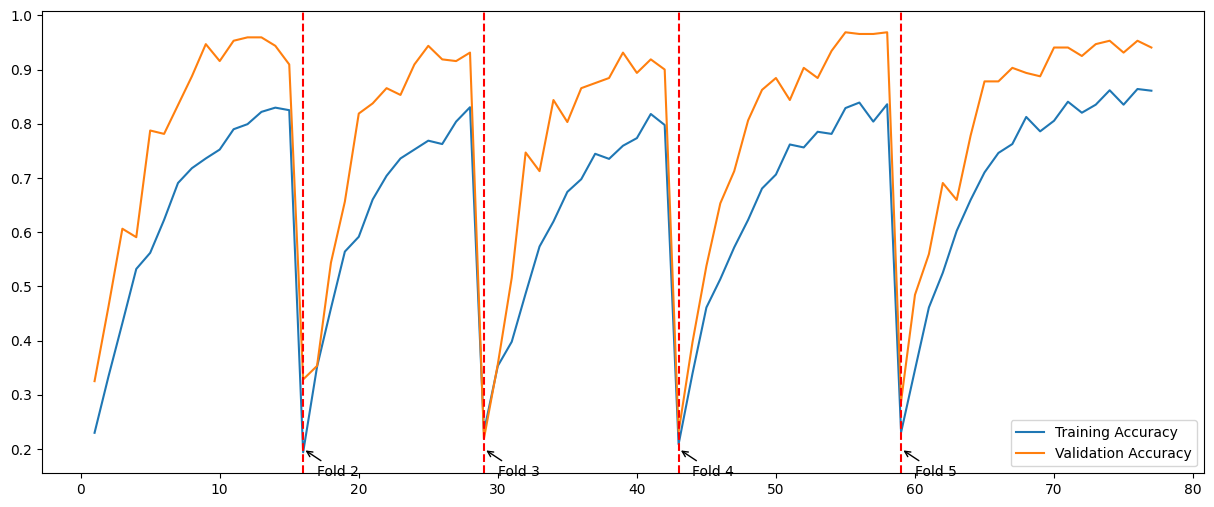

In [74]:
x1 = list(range(1, len(training_accuracy) + 1))
x2 = list(range(1, len(validation_accuracy) + 1))

fig = plt.figure(figsize=(15, 6))

# Create the plot
plt.plot(x1, training_accuracy, label='Training Accuracy')
plt.plot(x2, validation_accuracy, label='Validation Accuracy')



# Add points with labels
for i in range(config.cross_validation_k-1):
    plt.axvline(x=xs[i], color='red', linestyle='--')
# plt.axvline(x=xs[0], color='red', linestyle='--')
# plt.axvline(x=xs[1], color='red', linestyle='--')
# plt.axvline(x=xs[2], color='red', linestyle='--')
# plt.axvline(x=xs[3], color='red', linestyle='--')

# Add annotations to the lines
for i in range(config.cross_validation_k-1):
    plt.annotate('Fold '+str(i+2), xy=(xs[i], 0.2), xytext=(xs[i]+1, 0.15),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# plt.annotate('Fold 2', xy=(xs[0], 0.5), xytext=(xs[0]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 3', xy=(xs[1], 0.5), xytext=(xs[1]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 4', xy=(xs[2], 0.5), xytext=(xs[2]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 5', xy=(xs[3], 0.5), xytext=(xs[3]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.axvline(x=xs[4], color='red', linestyle='--')
# plt.scatter(xs, ys, color='red')
# plt.annotate('Point 1', (2, 4), textcoords="offset points", xytext=(0,10), ha='center')
# plt.annotate('Point 2', (4, 8), textcoords="offset points", xytext=(0,10), ha='center')


# Add a legend
plt.legend()

# Enable the grid
# plt.grid(True)

## Log Train - Val Accuracy Curve
wandb.log({'Train - Val Accuracy': wandb.Image(plt)})

# Show the plot
# plt.show()

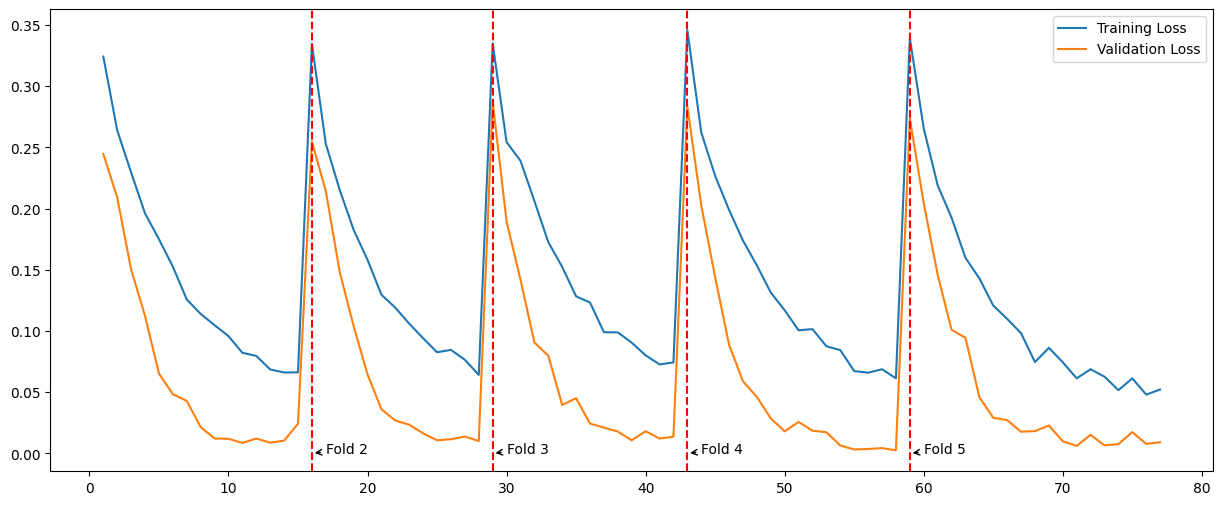

In [75]:
x1 = list(range(1, len(training_loss) + 1))
x2 = list(range(1, len(validation_loss) + 1))

fig = plt.figure(figsize=(15, 6))

# Create the plot
plt.plot(x1, training_loss, label='Training Loss')
plt.plot(x2, validation_loss, label='Validation Loss')



# Add points with labels
for i in range(config.cross_validation_k-1):
    plt.axvline(x=xs[i], color='red', linestyle='--')
# plt.axvline(x=xs[0], color='red', linestyle='--')
# plt.axvline(x=xs[1], color='red', linestyle='--')
# plt.axvline(x=xs[2], color='red', linestyle='--')
# plt.axvline(x=xs[3], color='red', linestyle='--')

# Add annotations to the lines
for i in range(config.cross_validation_k-1):
    plt.annotate('Fold '+str(i+2), xy=(xs[i], 0), xytext=(xs[i]+1, 0),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# plt.annotate('Fold 2', xy=(xs[0], 0.5), xytext=(xs[0]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 3', xy=(xs[1], 0.5), xytext=(xs[1]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 4', xy=(xs[2], 0.5), xytext=(xs[2]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 5', xy=(xs[3], 0.5), xytext=(xs[3]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.axvline(x=xs[4], color='red', linestyle='--')
# plt.scatter(xs, ys, color='red')
# plt.annotate('Point 1', (2, 4), textcoords="offset points", xytext=(0,10), ha='center')
# plt.annotate('Point 2', (4, 8), textcoords="offset points", xytext=(0,10), ha='center')


# Add a legend
plt.legend()

# Enable the grid
# plt.grid(True)

## Log Train - Val Accuracy Curve
wandb.log({'Train - Val Loss': wandb.Image(plt)})

# Show the plot
# plt.show()

## Log Unified Test Set and its predictions

In [76]:
prediction_names = [class_name_label[num] for num in predictions]
actual_names = [class_name_label[num] for num in y_test.numpy()]

In [77]:
pred_is_actual = [x == y for x, y in zip(prediction_names, actual_names)]

### Log Correct and Wrong Predictions as Images

In [78]:
# assuming you have lists of images, predictions, and actual labels
for i, (img, pred, label) in enumerate(zip(x_test, prediction_names, actual_names)):
    wandb.log({'All Predictions - Unified Test Set': wandb.Image(img, caption='predicted: {}, actual: {}'.format(pred, label))})
    
    if(pred_is_actual[i]):
        wandb.log({'Correct Predictions - Unified Test Set': wandb.Image(img, caption='predicted: {}, actual: {}'.format(pred, label))})
    else:
        wandb.log({'Wrong Predictions - Unified Test Set': wandb.Image(img, caption='predicted: {}, actual: {}'.format(pred, label))})

### Class accuracies

In [79]:
df_preds = pd.DataFrame({"actual": actual_names, "prediction": prediction_names, "correct": pred_is_actual})

In [80]:
# group the dataframe by the 'actual' column
grouped = df_preds.groupby('actual')
class_accuracy = pd.DataFrame(data={}, columns=['class', 'accuracy'])
# calculate the accuracy for each group
for name, group in grouped:
    accuracy = accuracy_score(group['actual'], group['prediction'])
    # print('Accuracy for class {}: {}'.format(name, accuracy))
    new_row = {"class": name, 'accuracy': accuracy}
    class_accuracy = pd.concat([class_accuracy, pd.DataFrame([new_row])], ignore_index=True)
class_accuracy = class_accuracy.sort_values('accuracy', ascending=True).reset_index(drop = True)

In [81]:
class_accuracy

,class,accuracy
0,Mountain,0.2
1,River,0.2
2,Natural,0.4
3,Snow,0.4
4,Cloud,0.6
5,Sea_ice,0.6
6,Agricultural,0.8
7,Water,0.8


In [82]:
# create a wandb.Table object from the dataframe
table = wandb.Table(dataframe=class_accuracy)
# log the table to wandb
wandb.log({'Class Accuracies': table})

In [83]:
wandb.finish()

Accuracy for model with best validation accuracy (Unified Test Set),▁
Accuracy for the ensemble model (Unified Test Set),▁
Best Validation Accuracy for Folds,▆▃▁█▅
Best Validation Loss for Folds,█▆▄▁▂
Cohen Kappa Score for model with best validation accuracy (Unified Test Set),▁
Cohen Kappa Score for the ensemble model (Unified Test Set),▁
Folds Validation Accuracy Mean,▁
Folds Validation Accuracy STD,▁
Test Set Size,▁
Training Validation Set Size,▁
Accuracy for model with best validation accuracy (Unified Test Set),0.475


In [ ]:
## Load the Model without any weight initialization
# model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
# model.summary()

In [ ]:
## Saving model
# model.save_weights('/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/submission/submit_19.h5')

In [ ]:
# model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
# # model = EfficientNetLiteB0(include_top=False, classes=num_classes, weights='imagenet', input_shape=input_shape, classifier_activation=None)
# model.load_weights('/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/submission/model_patterns_20epochs.h5')

The model will be now compiled and tested again. You should get the same score as before saving and loading. 